In this notebook we analyze the performance of our fine-tuned XLM-RoBERTa classifier.

# Load the Dataset

In [12]:
from datasets import load_dataset

emotion = load_dataset("emotion")
label_names = emotion["train"].features["label"].names
id2label = {i: l for i, l in enumerate(label_names)}
label2id = {l: i for i, l in enumerate(label_names)}

# Load the Fine-Tuned Model

In [6]:
from transformers import AutoTokenizer, pipeline

model_name = "xlm-roberta-base-finetuned-emotion"
model_on_hub = f"florianehmann/{model_name}"

classifier = pipeline("text-classification", model=model_on_hub)
tokenizer = AutoTokenizer.from_pretrained(model_on_hub)

# Analyze the Results

## Determine a Confusion Matrix

In [8]:
import pandas as pd

emotion.reset_format()
predictions = classifier.predict(emotion["validation"]["text"])

In [46]:
emotion.set_format('pandas')

pred_df = pd.DataFrame(predictions)
pred_df = pred_df.rename(columns={"label": "predicted_label_name"})
pred_df["predicted_label_id"] = pred_df["predicted_label_name"].apply(lambda n: label2id[n])
pred_df["true_label_id"] = emotion["validation"][:]["label"]
pred_df["true_label_name"] = pred_df["true_label_id"].apply(lambda i: id2label[i])

pred_df = pred_df[pred_df.columns[[3, 2, 4, 0, 1]]]

In [47]:
pred_df.head(5)


,true_label_id,predicted_label_id,true_label_name,predicted_label_name,score
0,0,0,sadness,sadness,0.995667
1,0,0,sadness,sadness,0.996707
2,2,2,love,love,0.766160
3,3,3,anger,anger,0.994905
4,1,1,joy,joy,0.995990


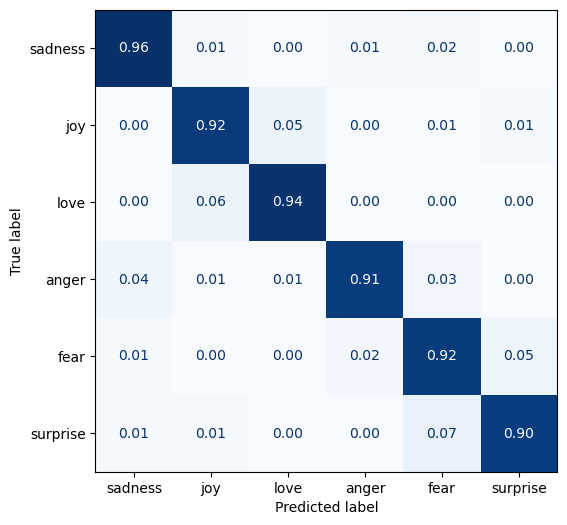

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(pred_df["true_label_id"], pred_df["predicted_label_id"], normalize='true')
fig, ax = plt.subplots(figsize=(6,6))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)

plt.show()

Curiously, this model does well more consistently than the fine-tuned DistilBERT model. We have accuracies (true positives) above 90% across all classes.

The largest off-diagonal entries are between (true/predicted) _surprise/fear_, _love/joy_ and _joy/love_. The scores between love and joy are not that high and we know from our analysis of the performance of the fine-tuned DistilBERT model that there are some mislabled tweets in the dataset, so that result is not particularly worrying. Before we look into that, however, we can take a look into the _surprise/fear_ misclassifications.

## Look Into Surprise/Fear Misclassification

In [57]:
misclassification_df = pred_df[(pred_df["true_label_name"] == "surprise") &
                               (pred_df["predicted_label_name"] == "fear")]
emotion.set_format("pandas")
misclassification_df.insert(0, "text",
    value=emotion["validation"][:]
    .loc[misclassification_df.index]["text"]
)

In [60]:
import textwrap

for text in misclassification_df['text'].values:
    wrapped_text = textwrap.fill(text, width=80, initial_indent='> ', subsequent_indent='  ')
    print(wrapped_text, end='\n\n\n')

> i think it is the worst feeling it gives me the shivers and just thinking
  about it makes my teeth feel strange


> i go around people and i act normal but it feels strange


> i feel really strange about this


> i do remember my left quad starting to feel strange not hurting yet an
  aggravating feeling about a week or two before the marathon


> i feel a strange type of peace with this go around that i never felt with ally


> i am feeling overwhelmed i dont feel hopeless to often but i do cycle through
  frustration anxiety and sometimes anger that i have to go through this




I think those are mostly mislabled data again. Except for the fifth those read more like anxiety than surprise or fear.